In [128]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [289]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
demand_ts = demand_data['demand']

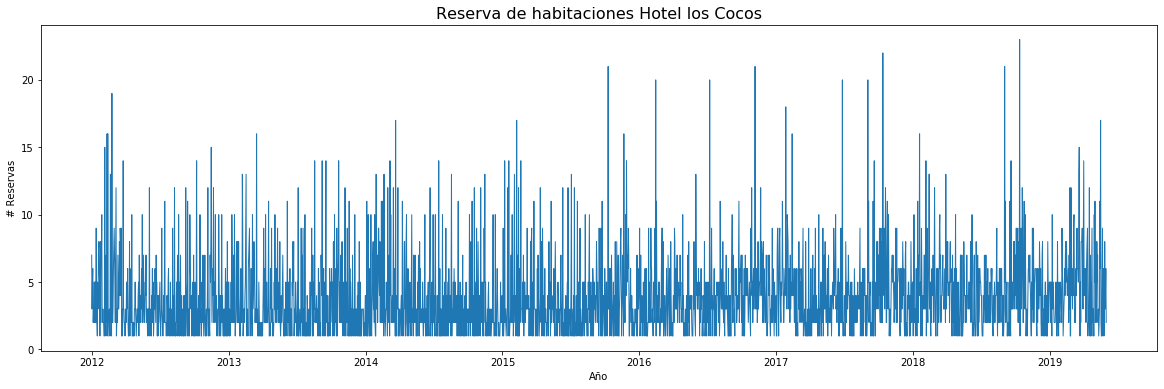

In [290]:
#Plot
plt.plot(demand_ts, linewidth=1)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [291]:
#Dividir datos de prueba y entrenamiento
train = demand_ts[:'2018']
test = demand_ts['2019':]

print(len(train))
print(len(test))

2555
151


In [292]:
#demand_ts['2012':'2018']

In [293]:
TS = np.array(demand_ts)
num_periods = 183
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 1, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 1, 1)

In [294]:
#TS

In [295]:
print("x_data:")
print(x_data.shape)
#print("\n x_batches:")
#print(x_batches)
print("\n x_batches shape:")
print(x_batches.shape)

#print("\n y_data:")
#print(y_data)

print("\n y_data:")
print(y_data.shape)
#print("\n y_batches:")
#print(y_batches)
print("\n y_batches shape:")
print(y_batches.shape)

x_data:
(2562,)

 x_batches shape:
(2562, 1, 1)

 y_data:
(2562,)

 y_batches shape:
(2562, 1, 1)


In [296]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 1, 1)
    testY = TS[-(num_periods):].reshape(-1, 1, 1)
    return testX,testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)


In [297]:
print("\n X_test shape")
print(X_test.shape)

print("\n Y_test shape")
print(Y_test.shape)

print("\n X_test")
#print(X_test)


 X_test shape
(183, 1, 1)

 Y_test shape
(183, 1, 1)

 X_test


In [298]:
tf.reset_default_graph()

num_periods = 1
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

#BasicRNNCell
#BasicLSTMCell
learning_rate = 0.01

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])


loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [299]:
epochs = 2000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 57980.062
100 	MSE: 23400.555
200 	MSE: 23314.904
300 	MSE: 23282.582
400 	MSE: 23262.287
500 	MSE: 23245.906
600 	MSE: 23235.525
700 	MSE: 23228.457
800 	MSE: 23221.96
900 	MSE: 23215.46
1000 	MSE: 23209.076
1100 	MSE: 23202.535
1200 	MSE: 23196.406
1300 	MSE: 23191.504
1400 	MSE: 23188.463
1500 	MSE: 23186.79
1600 	MSE: 23185.74
1700 	MSE: 23184.596
1800 	MSE: 23182.555
1900 	MSE: 23179.766


In [300]:
y_pred.shape

(183, 1, 1)

In [301]:
indDates1 = pd.date_range(start = '2012-01-01', periods=len(X_test), freq='D')
indDates2 = pd.date_range(start = '2019-01-01', periods=len(Y_test), freq='D')


In [302]:
#Xtest = pd.DataFrame(X_test.ravel(), index=indDates1)
#Xtest

In [303]:
Ytest = pd.DataFrame(Y_test.ravel(), index=indDates2)
#Ytest

In [304]:
YPred = pd.DataFrame(y_pred.ravel(), index=indDates2)
#YPred

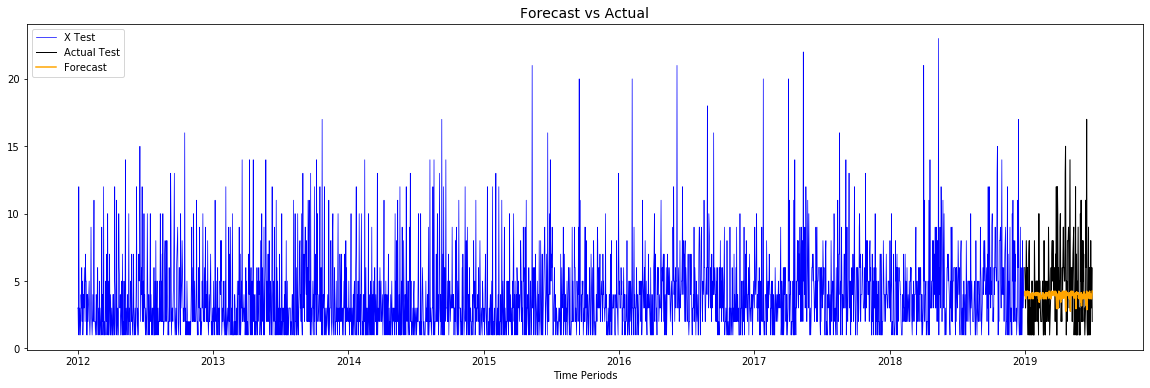

In [305]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot( Xtest, 'blue', label="X Test", linewidth=0.7)
plt.plot( Ytest, 'black', label="Actual Test", linewidth=1)
plt.plot( YPred, 'orange', label="Forecast", linewidth=1.5)
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

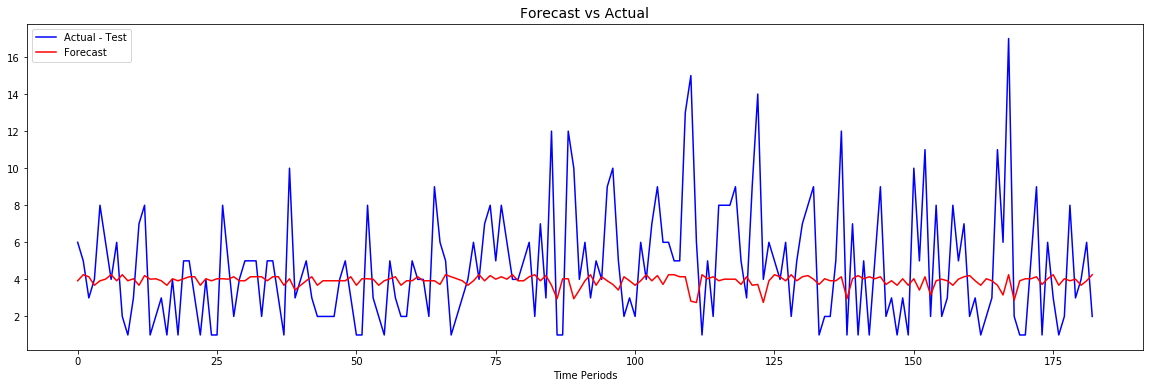

In [306]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', label="Actual - Test")
plt.plot(pd.Series(np.ravel(y_pred)), 'r', label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

In [307]:
print("Y_test shape: ",Y_test.shape)
print("y_pred shape: ",y_pred.shape)

Y_test shape:  (183, 1, 1)
y_pred shape:  (183, 1, 1)


In [308]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import sqrt

#### MAPE (Mean Absolute Percentage Error)

In [309]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(Y_test,y_pred )

78.73070120497836

#### MAD (Median absolute deviation)

In [285]:
#median_absolute_error(Y_test,y_pred)

#### MAE (Mean Absolute Error)

In [288]:
#mean_absolute_error(Y_test,y_pred )

#### MSE (Mean Squared Error)

In [ ]:
mean_squared_error(Y_test,y_pred )

#### RMSE (Root Mean Square error)

In [ ]:
sqrt( mean_squared_error(Y_test,y_pred ) ) 

In [100]:
pd.set_option('display.max_columns', 3000)
pd.options.display.max_columns = 1600
pd.options.display.max_rows = 160

In [101]:
YPred

,0
2019-01-01,3.930259
2019-01-02,4.275200
2019-01-03,4.098535
2019-01-04,3.682900
2019-01-05,3.892833
2019-01-06,4.165549
2019-01-07,4.275200
2019-01-08,3.892833
2019-01-09,4.275200
2019-01-10,3.930259
